This all data and detail is from : 
https://www.kaggle.com/c/home-credit-default-risk/data


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from google.colab import drive

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
path  = '/content/gdrive/MyDrive/Colab data source/Home Credit risk/'
pd.set_option('display.float_format', lambda x: '%.5f' % x)
train = pd.read_csv(path+'application_train.csv')
test = pd.read_csv(path+'application_test.csv')
bureau_balance = pd.read_csv(path+'bureau_balance.csv')
POS_balance= pd.read_csv(path+'POS_CASH_balance.csv')
prev_app= pd.read_csv(path+'previous_application.csv')
credit_card_bal = pd.read_csv(path+'credit_card_balance.csv')
install_payment = pd.read_csv(path+'installments_payments.csv')
bureau  =pd.read_csv(path + 'bureau.csv')

# Explore Data & Cleaning Data

In [6]:
def showna (df ):
  print('Full frame : '+ str(len(df)))
  cnt = 0 
  for (colname , coldata) in df.iteritems():
    
    lost_percentage =  (df[colname].isna().sum()/len(df))*100
    if(lost_percentage!= 0 ):
      cnt+=1
      print(colname +' : ' +str( df[colname].isna().sum()) +' loss as : '+ str(lost_percentage)+'%')
  print("cnt lost columns : "+ str(cnt))

In [7]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,351000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01880,-9461,-637,-3648.00000,-2120,nan,1,1,0,1,1,0,Laborers,1.00000,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.02050,0.01930,0.00000,0.00000,reg oper account,block of flats,0.01490,"Stone, brick",No,2.00000,2.00000,2.00000,2.00000,-1134.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,1129500.00000,Family,State servant,Higher education,Married,House / apartment,0.00354,-16765,-1188,-1186.00000,-291,nan,1,1,0,1,1,0,Core staff,2.00000,1,1,MONDAY,11,0,0,0,0,0,0,...,0.07870,0.05580,0.00390,0.01000,reg oper account,block of flats,0.07140,Block,No,1.00000,0.00000,1.00000,0.00000,-828.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,135000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01003,-19046,-225,-4260.00000,-2531,26.00000,1,1,1,1,1,0,Laborers,1.00000,2,2,MONDAY,9,0,0,0,0,0,0,...,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-815.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.50000,29686.50000,297000.00000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.00802,-19005,-3039,-9833.00000,-2437,nan,1,1,0,1,0,0,Laborers,2.00000,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,2.00000,0.00000,2.00000,0.00000,-617.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan
4,100007,0,Cash loans,M,N,Y,0,121500.00000,513000.00000,21865.50000,513000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02866,-19932,-3038,-4311.00000,-3458,nan,1,1,0,1,0,0,Core staff,1.00000,2,2,THURSDAY,11,0,0,0,0,1,1,...,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-1106.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [8]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307499.00000,307233.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,104582.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307509.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,134133.00000,306851.00000,246546.00000,151450.00000,127568.00000,157504.00000,103023.00000,92646.00000,143620.00000,152683.00000,154491.00000,...,152683.00000,154491.00000,98869.00000,124921.00000,97312.00000,153161.00000,93997.00000,137829.00000,159080.00000,306490.00000,306490.00000,306490.00000,306490.00000,307510.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000
mean,278180.51858,0.08073,0.41705,168797.91930,599025.99971,27108.57391,538396.20743,0.02087,-16036.99507,63815.04590,-4986.12033,-2994.20237,12.06109,1.00000,0.81989,0.19937,0.99813,0.28107,0.05672,2.15267,2.05246,2.03152,12.06342,0.01514,0.05077,0.04066,0.07817,0.23045,0.17955,0.50213,0.51439,0.51085,0.11744,0.08844,0.97773,0.75247,0.04462,0.07894,0.14972,0.22628,...,0.14921,0.22590,0.23162,0.06717,0.10195,0.10861,0.00865,0.02824,0.10255,1.42225,0.14342,1.40529,0.10005,-962.85879,0.00004,0.71002,0.00008,0.01511,0.08806,0.00019,0.08138,0.00390,0.00002,0.00391,0.00001,0.00353,0.00294,0.00121,0.00993,0.00027,0.00813,0.00060,0.00051,0.00033,0.00640,0.00700,0.03436,0.26740,0.26547,1.89997
std,102790.17535,0.27242,0.72212,237123.14628,402490.77700,14493.73732,369446.46054,0.01383,4363.98863,141275.76652,3522.88632,1509.45042,11.94481,0.00180,0.38428,0.39953,0.04316,0.44952,0.23131,0.91068,0.50903,0.50274,3.26583,0.12213,0.21953,0.19750,0.26844,0.42112,0.38382,0.21106,0.19106,0.19484,0.10824,0.08244,0.05922,0.11328,0.07604,0.13458,0.10005,0.14464,...,0.10037,0.14507,0.16193,0.08217,0.09364,0.11226,0.04741,0.07017,0.10746,2.40099,0.44670,2.37980,0.36229,826.80849,0.00650,0.45375,0.00902,0.12201,0.28338,0.01385,0.27341,0.06229,0.00477,0.06242,0.00255,0.05927,0.05411,0.03476,0.09914,0.01633,0.08980,0.02439,0.02252,0.01830,0.08385,0.11076,0.20468,0.91600,0.79406,1.86929
min,100002.00000,0.00000,0.00000,25650.00000,45000.00000,1615.50000,40500.00000,0.00029,-25229.00000,-17912.00000,-2

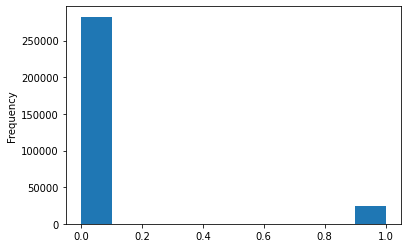

In [9]:
train['TARGET'].plot.hist()

from above graph we can see the problem we call imbalance dataset ,
 May be we have to resample it or may be try some model that great with imbalance dataset such as random forest.

In [10]:
showna(train)

Full frame : 307511
AMT_ANNUITY : 12 loss as : 0.003902299429939092%
AMT_GOODS_PRICE : 278 loss as : 0.09040327012692229%
NAME_TYPE_SUITE : 1292 loss as : 0.42014757195677555%
OWN_CAR_AGE : 202929 loss as : 65.9908100848425%
OCCUPATION_TYPE : 96391 loss as : 31.345545362604916%
CNT_FAM_MEMBERS : 2 loss as : 0.0006503832383231819%
EXT_SOURCE_1 : 173378 loss as : 56.381072546998325%
EXT_SOURCE_2 : 660 loss as : 0.21462646864665005%
EXT_SOURCE_3 : 60965 loss as : 19.825307062186393%
APARTMENTS_AVG : 156061 loss as : 50.74972927797705%
BASEMENTAREA_AVG : 179943 loss as : 58.51595552679416%
YEARS_BEGINEXPLUATATION_AVG : 150007 loss as : 48.781019215572776%
YEARS_BUILD_AVG : 204488 loss as : 66.49778381911543%
COMMONAREA_AVG : 214865 loss as : 69.87229725115525%
ELEVATORS_AVG : 163891 loss as : 53.29597965601231%
ENTRANCES_AVG : 154828 loss as : 50.3487680115508%
FLOORSMAX_AVG : 153020 loss as : 49.76082156410665%
FLOORSMIN_AVG : 208642 loss as : 67.84862980511267%
LANDAREA_AVG : 182590 loss

We saw that there a lot of null value in dataframe so  we have to deal with it we can't drop these all because there a lot of missing vaues may be we have to impute   data or  use some special ML such as XGboost that can handle these missing value but I won't decide that now let take a look for other factors .

Let's check type of each columns is if tell us something . 

In [11]:
train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [12]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [13]:
train.select_dtypes('object').apply(pd.Series.nunique,axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

There are a lot of category value we will have to encoding it later , due to a lot of type per  column  one-hot encoding will make it a larger dataframe but if we use label encoding it's not good because it will value one type over another without reasonable reason so I will decide to use one-hot encoding then reduce dimension later  may be using PCA.

Let's check anomalies and outliers. 

In [14]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307499.00000,307233.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,104582.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307509.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,134133.00000,306851.00000,246546.00000,151450.00000,127568.00000,157504.00000,103023.00000,92646.00000,143620.00000,152683.00000,154491.00000,...,152683.00000,154491.00000,98869.00000,124921.00000,97312.00000,153161.00000,93997.00000,137829.00000,159080.00000,306490.00000,306490.00000,306490.00000,306490.00000,307510.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000
mean,278180.51858,0.08073,0.41705,168797.91930,599025.99971,27108.57391,538396.20743,0.02087,-16036.99507,63815.04590,-4986.12033,-2994.20237,12.06109,1.00000,0.81989,0.19937,0.99813,0.28107,0.05672,2.15267,2.05246,2.03152,12.06342,0.01514,0.05077,0.04066,0.07817,0.23045,0.17955,0.50213,0.51439,0.51085,0.11744,0.08844,0.97773,0.75247,0.04462,0.07894,0.14972,0.22628,...,0.14921,0.22590,0.23162,0.06717,0.10195,0.10861,0.00865,0.02824,0.10255,1.42225,0.14342,1.40529,0.10005,-962.85879,0.00004,0.71002,0.00008,0.01511,0.08806,0.00019,0.08138,0.00390,0.00002,0.00391,0.00001,0.00353,0.00294,0.00121,0.00993,0.00027,0.00813,0.00060,0.00051,0.00033,0.00640,0.00700,0.03436,0.26740,0.26547,1.89997
std,102790.17535,0.27242,0.72212,237123.14628,402490.77700,14493.73732,369446.46054,0.01383,4363.98863,141275.76652,3522.88632,1509.45042,11.94481,0.00180,0.38428,0.39953,0.04316,0.44952,0.23131,0.91068,0.50903,0.50274,3.26583,0.12213,0.21953,0.19750,0.26844,0.42112,0.38382,0.21106,0.19106,0.19484,0.10824,0.08244,0.05922,0.11328,0.07604,0.13458,0.10005,0.14464,...,0.10037,0.14507,0.16193,0.08217,0.09364,0.11226,0.04741,0.07017,0.10746,2.40099,0.44670,2.37980,0.36229,826.80849,0.00650,0.45375,0.00902,0.12201,0.28338,0.01385,0.27341,0.06229,0.00477,0.06242,0.00255,0.05927,0.05411,0.03476,0.09914,0.01633,0.08980,0.02439,0.02252,0.01830,0.08385,0.11076,0.20468,0.91600,0.79406,1.86929
min,100002.00000,0.00000,0.00000,25650.00000,45000.00000,1615.50000,40500.00000,0.00029,-25229.00000,-17912.00000,-2

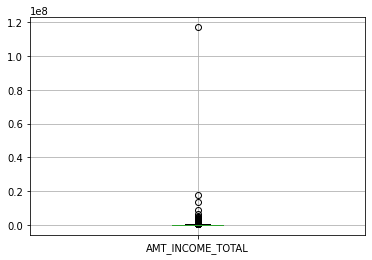

In [15]:
train.boxplot(column ='AMT_INCOME_TOTAL')

The max value is very very extreme outlier so we will drop it.

In [16]:
train  = train.drop(train[train['AMT_INCOME_TOTAL']== train['AMT_INCOME_TOTAL'].max()].index)

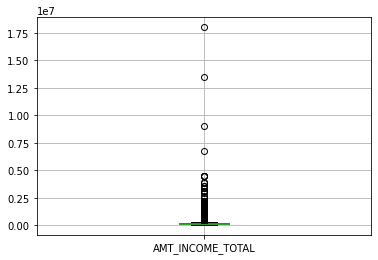

In [17]:
train.boxplot(column = 'AMT_INCOME_TOTAL')

It's look better and we will not drop other outlier because from graph it skew data . 

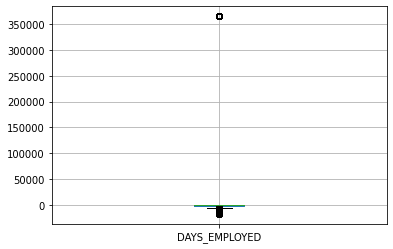

In [18]:
train.boxplot(column = 'DAYS_EMPLOYED')

The days employ should be negative (relate to application date) so this row has a chance to be anomalies data and we'll drop it. 

In [19]:
train  = train.drop(train[train['DAYS_EMPLOYED']== train['DAYS_EMPLOYED'].max()].index)


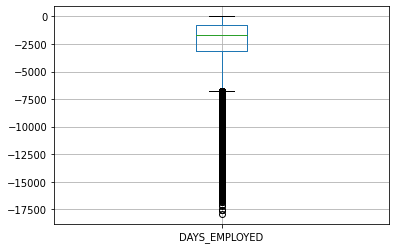

In [20]:
train.boxplot(column = 'DAYS_EMPLOYED')

In [21]:
train['Age']= train['DAYS_BIRTH']/-365
test['Age']= test['DAYS_BIRTH']/-365

In [22]:
train['Work_year'] =  train['DAYS_EMPLOYED']/-365
test['Work_year'] =  test['DAYS_EMPLOYED']/-365


In [23]:
train.drop(columns = ['DAYS_BIRTH','DAYS_EMPLOYED'],axis = 1 ,inplace  = True)
test.drop(columns = ['DAYS_BIRTH','DAYS_EMPLOYED'],axis = 1,inplace  = True )


Test Correlation with Target

In [24]:
correlation = train.corr()['TARGET'].sort_values(ascending  = False,key =abs)

In [25]:
correlation.head(15)

TARGET                         1.00000
EXT_SOURCE_3                  -0.17974
EXT_SOURCE_2                  -0.17051
EXT_SOURCE_1                  -0.15535
Work_year                     -0.07495
REGION_RATING_CLIENT_W_CITY    0.06746
Age                           -0.06575
REGION_RATING_CLIENT           0.06512
DAYS_LAST_PHONE_CHANGE         0.06027
AMT_GOODS_PRICE               -0.05034
FLOORSMAX_AVG                 -0.04946
FLOORSMAX_MEDI                -0.04915
FLOORSMAX_MODE                -0.04855
REG_CITY_NOT_WORK_CITY         0.04339
REG_CITY_NOT_LIVE_CITY         0.04198
Name: TARGET, dtype: float64

form the correlation table there's nor strong correlation between any features and target , may be the relatoin is not a linear or may it  need additoinal features . Let's test polynomial features . 

# Features Engineering

To transform polynomialit use a lot of computatioan cost so  I will limit features up to 10  I will select top 10 by correlation.

In [40]:
features_for_poly  = correlation[1:10].index.to_list()

In [41]:
poly_features_train = train[features_for_poly]
poly_features_test = test[features_for_poly]


In [42]:
imputer = SimpleImputer(strategy = 'median') # due to we have many outlier mean is not a good choice.
poly_features_train= imputer.fit_transform(poly_features_train)
poly_features_test= imputer.fit_transform(poly_features_test)


In [43]:
transformer =  PolynomialFeatures(degree= 3)
transformer.fit(poly_features_train)
poly_features_train = transformer.transform(poly_features_train)
poly_features_test = transformer.transform(poly_features_test)


In [44]:
target = train['TARGET'].copy()

In [45]:
# convert these to data frame 
poly_features_train  =  pd.DataFrame(poly_features_train, columns = transformer.get_feature_names(input_features=features_for_poly))
poly_features_train['TARGET'] = target

In [46]:
poly_corr = poly_features_train.corr()['TARGET'].sort_values(ascending  = False,key =abs)
poly_corr.head(15)

TARGET                                                      1.00000
EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT              0.00389
EXT_SOURCE_3 EXT_SOURCE_1                                   0.00377
EXT_SOURCE_3 EXT_SOURCE_1 DAYS_LAST_PHONE_CHANGE           -0.00371
EXT_SOURCE_3 EXT_SOURCE_1 Age                               0.00366
EXT_SOURCE_3^2 EXT_SOURCE_1                                 0.00346
EXT_SOURCE_3 REGION_RATING_CLIENT DAYS_LAST_PHONE_CHANGE   -0.00345
EXT_SOURCE_3^2 DAYS_LAST_PHONE_CHANGE                      -0.00344
EXT_SOURCE_3 Age DAYS_LAST_PHONE_CHANGE                    -0.00342
EXT_SOURCE_3 Age^2                                          0.00333
EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY       0.00331
EXT_SOURCE_3 DAYS_LAST_PHONE_CHANGE                        -0.00330
EXT_SOURCE_3 Age                                            0.00326
EXT_SOURCE_3 Age REGION_RATING_CLIENT                       0.00323
EXT_SOURCE_1 REGION_RATING_CLIENT DAYS_LAST_PHON

# Data Preparation

# Train Model 

# Evaluate

# Conclusion